# Wicklow isolates snpgenie analysis

* https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000388?crawler=true

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snpgenie import tools, aligners, app, trees, plotting

In [8]:
meta = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/sampleInformation_NoAnimalIDs_18-12-19.csv')
meta=meta[meta.County=='Wicklow']

## Run workflow 

Add outgroup samples from Northern Ireland? UK?


In [ ]:
reload(app)
reload(tools)
args = {'threads':12, 'outdir': '/storage/btbgenie/wicklow_results', 'labelsep':'_',
        'input':['/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_07-01-18/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_15-03-19/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/Fastqs_09-07-18/',
                 '/storage/btbgenie/JoeROIData/Mbovis/Wicklow/dog',
                 '/storage/btbgenie/JoeROIData/Mbovis/NI'],
         'reference': None, 'overwrite':False,
         'trim': False,
         'filters' : 'QUAL>=30 & FMT/DP>=30 && DP4>=4 && MQ>35',
         'custom_filters': True,
         'mask': app.mbovis_mask,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [50]:
meta[:4]

,SeqID,Forward,Reverse,NumberMapped,MappingProp,SequencingDate,County,VCF,Coverage,AverageDepth,Aliquot,Species,Date,color
0,1034,1034_S91_L001-4_R1_001.fastq.gz,1034_S91_L001-4_R2_001.fastq.gz,902962,0.999386,24-09-19,Wicklow,1034_1.vcf.gz,0.900721,27.709380,TB19-001034,Dog,NaN,green
4,13-11594,13-11594_S85_L001-4_R1_001.fastq.gz,13-11594_S85_L001-4_R2_001.fastq.gz,2988951,0.999445,15-03-19,Wicklow,13-11594_2.vcf.gz,0.984226,88.893592,TB14-011594,Deer,2014-11-12,black
5,14-MBovis,14-MBovis_S21_L001-4_R1_001.fastq.gz,14-MBovis_S21_L001-4_R2_001.fastq.gz,4252719,0.999071,09-07-18,Wicklow,14-MBovis_1.vcf.gz,0.993205,128.951745,TB14-013251,Deer,2014-12-16,black
11,15-11643,15-11643_S67_L001-4_R1_001.fastq.gz,15-11643_S67_L001-4_R2_001.fastq.gz,3199584,0.999504,15-03-19,Wicklow,15-11643_3.vcf.gz,0.982719,95.385965,TB14-011643,Deer,2014-11-13,black


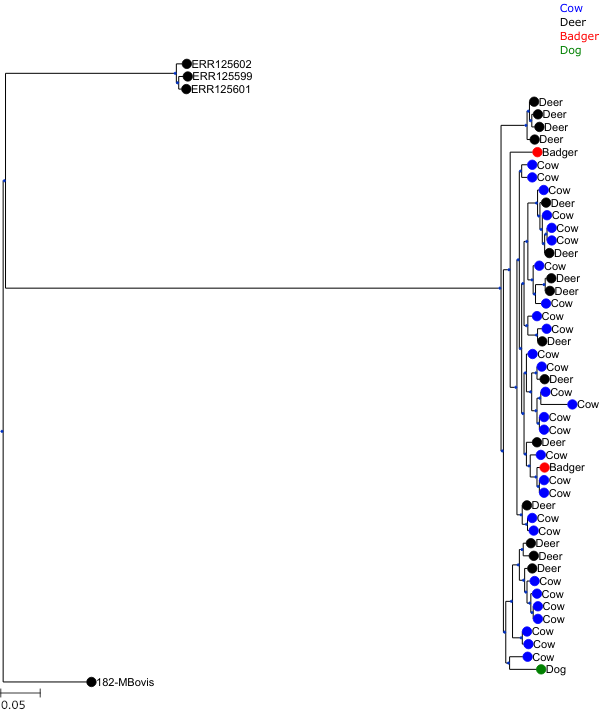

In [51]:
labelmap = dict(zip(meta['SeqID'],meta.Species))
colors = {'Cow': 'blue', 'Deer': 'black','Badger':'red', 'Dog':'green'}
meta['color'] = meta.Species.apply(lambda x: colors[x],1)
colormap = dict(zip(meta['SeqID'],meta.color))
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', 'ref', labelmap=labelmap, colormap=colormap)
#R = t.get_midpoint_outgroup()
#t.set_outgroup(R)
#trees.delete_nodes(t, ['182-MBovis'])
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=10),            
            column=0)
ts.scale=1000
N = t.search_nodes(name="ref")[0]
N.delete()
t.render("%%inline",tree_style=ts,w=600)

## snp distance matrix

In [ ]:
sm = pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv',index_col=0)
sm=sm.rename(columns=labelmap,index=labelmap)
sm[:3]
#plotting.plot_matrix(sm, cmap='gray',w=8)

## RD analysis

In [ ]:
from snpgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/wicklow_rd',threads=12)

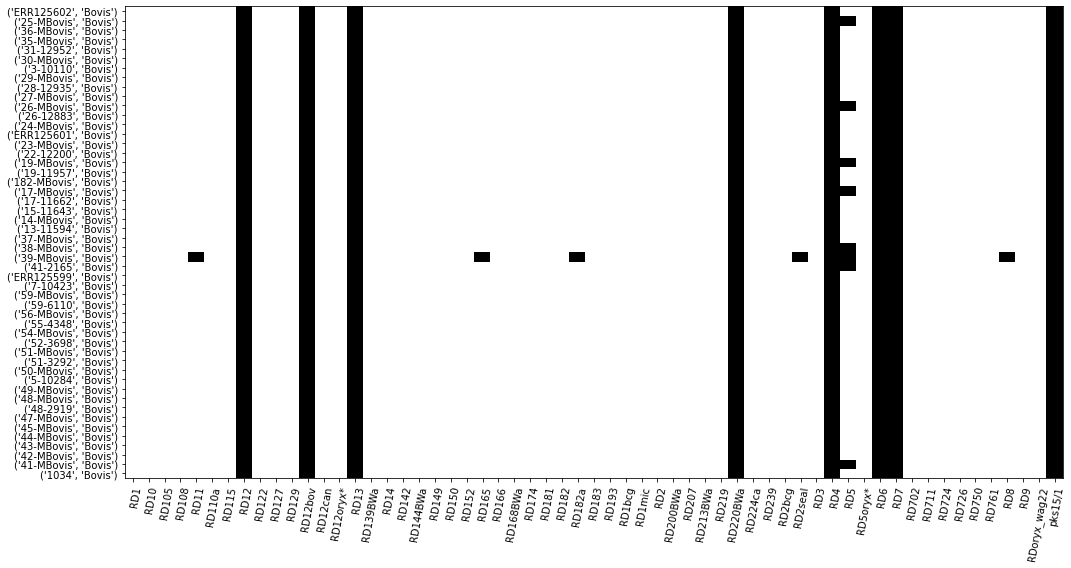

In [53]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
plotting.heatmap(X.set_index('ident',append=True), cmap='cubehelix',h=8)
#plt.savefig('rd_wicklow.png')

# vs JC pipeline results
## Compare sites matrix

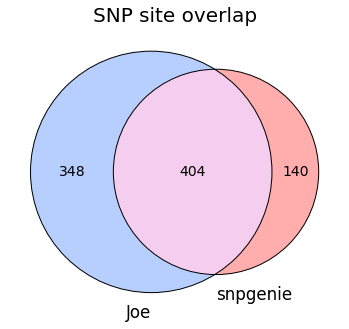

In [54]:
smat = pd.read_csv('/storage/btbgenie/wicklow_results/core.txt',sep=' ',index_col=0)
smat.index
joe_sites = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/FASTA/fastaPositions_Prox-10_18-12-2019.txt')
#print (joe_sites)
plt.figure(figsize=(6,6))
import matplotlib_venn
#mpl.rc('text', usetex=True)
mpl.rc('font',size=14)
sets=[set(joe_sites.Position),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Joe','snpgenie'],set_colors=['#4d88ff','#ff3333'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_joe.png',dpi=100)

## identify non overlapping sites

In [55]:
df = app.read_csq_file('/storage/btbgenie/wicklow_results/csq.tsv')
x = df.set_index(['start','gene','aa','sample'])['nuc'].unstack('sample')

len(x), len(smat)

(524, 544)

In [ ]:
n=list(set(joe_sites.Position) - set(smat.index))
csqmat = pd.read_csv('../test_results/csq.matrix')#.set_index(['gene','aa'])
x[x.start.isin(n)]

In [59]:
#frequencies of sites
sitefreqs = (csqmat.sum(1)/len(csqmat.columns)).sort_values(ascending=False)
sitefreqs.value_counts()

0.0625    1798
0.1875     881
0.1250     403
0.7500     153
0.6875      77
0.8750      64
0.2500      36
0.4375      21
0.5000      10
0.6250       6
0.3750       3
0.5625       3
0.3125       2
dtype: int64

In [6]:
#print(W.fastq_table)
meta['name'] = meta.Forward.apply(lambda x: x.split('.')[0])
print(meta.loc[0])
s = pd.merge(W.fastq_table,meta,on='name')
labelmap = dict(zip(s['sample'],s.County))
#print (labelmap)


SeqID                                        1034
Forward           1034_S91_L001-4_R1_001.fastq.gz
Reverse           1034_S91_L001-4_R2_001.fastq.gz
NumberMapped                               902962
MappingProp                              0.999386
SequencingDate                           24-09-19
County                                   Monaghan
VCF                                 1034_1.vcf.gz
Coverage                                 0.900721
AverageDepth                              27.7094
Aliquot                               TB19-001034
Species                                       NaN
Date                                          NaN
name                       1034_S91_L001-4_R1_001
Name: 0, dtype: object


In [ ]:
reload(trees)
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', ref='ref',labelmap=labelmap)
t.render("%%inline",tree_style=ts)

## Compare trees

In [ ]:
reload(trees)
t = trees.create_tree('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/mlTree_WICKLOW_18-12-2019.tree')#, labelmap)
t.render("%%inline")